<a href="https://colab.research.google.com/github/namyh/hw3/blob/main/seq2seq_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [1]:
!mamba install -c conda-forge rdkit

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
pillow                   [] (00m:00s) Waiting...
tornado                  [] (00m:00s) Waiting...
xorg-kbproto             [] (00m:00s) Waiting...
reportlab                [] (00m:00s) Waiting...
xorg-libsm               [] (00m:00s) Waiting...
xorg-libxext             [] (00m:00s) Waiting...
xorg-renderproto         [] (00m:00s) Waiting...
xorg-xproto              [] (00m:00s) Waiting...
cycler                   [] (00m:00s) Waiting...
greenlet                 [] (00m:00s) Waiting...
freetype                 [] (00m:00s) Waiting...
lcms2                    [] (00m:00s) Waiting...
libpng                   [] (00m:00s) Waiting...
libgfortran5             [] (00m:00s) Waiting...
libwebp-base             [] (00m:00s) Waiting...
numpy                    [] (00m:00s)      4 MB /      6 MB (  3.16 MB/s)
pycairo                  [] (00m:00s) Waiting...
pcre                     [] (00m:00s) Waiting...
typing_extensions        [] (00m:00s) Waiting...
xorg-xex

In [2]:
pip install --pre deepchem

     |████████████████████████████████| 564 kB 35.8 MB/s 
     |████████████████████████████████| 22.3 MB 57.7 MB/s 
     |████████████████████████████████| 303 kB 78.7 MB/s 
     |████████████████████████████████| 27.4 MB 139 kB/s 


In [3]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

os.chdir("/content/drive/My Drive/")  

In [6]:
pip install sklearn.cross_validation

ERROR: Could not find a version that satisfies the requirement sklearn.cross_validation
ERROR: No matching distribution found for sklearn.cross_validation


In [7]:
smifile = "GDB4c.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)


(687097,)
(229033,)


In [8]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'[', 'n', '=', ']', '(', 'C', 'c', 'N', 'H', 'E', ' ', ')', '7', '3', '5', '!', '1', '6', '2', '4', '8', '9', '-', '0'}
24 57


C1CCCC2(CC1)C1CCC3CCC3C2CC1 147592


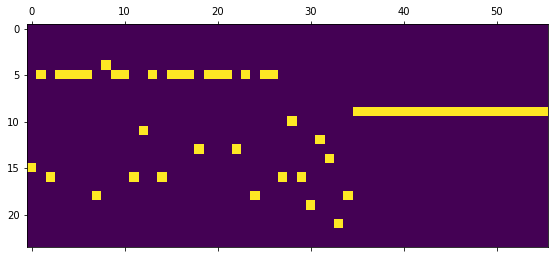

In [9]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)

In [10]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!C1CCCC2(CC1)C1CCC3CCC3C2CC1 147592EEEEEEEEEEEEEEEEEEEEE'

In [11]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [12]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [13]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 24)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  22784       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

In [14]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)


In [15]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Epoch 1/200
2684/2684 [==============================] - ETA: 0s - loss: 0.7244

ValueError: ignored

In [ ]:
import pickle
pickle.dump(h.history, file("Blog_history.pickle","w"))